In [2]:
from pathlib import Path

import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy import table
from astropy.io import fits
from astropy.modeling import models, fitting

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm.auto import tqdm

from IPython import display

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


In [4]:
phottab = table.Table.read('spectrophotometry.ecsv', format='ascii.ecsv')
phottab.colnames

['specname',
 'absmag_F275W_vega',
 'absmag_F275W_AB',
 'absmag_F275W_ST',
 'absmag_F336W_vega',
 'absmag_F336W_AB',
 'absmag_F336W_ST',
 'absmag_F475W_vega',
 'absmag_F475W_AB',
 'absmag_F475W_ST',
 'absmag_F814W_vega',
 'absmag_F814W_AB',
 'absmag_F814W_ST',
 'absmag_F110W_vega',
 'absmag_F110W_AB',
 'absmag_F110W_ST',
 'absmag_F160W_vega',
 'absmag_F160W_AB',
 'absmag_F160W_ST']

In [5]:
phottensors = []
bandnms = 'F275W,F336W,F475W,F814W,F110W,F160W'.split(',')
for bandnm in bandnms:
    phottensors.append(torch.from_numpy(phottab[f'absmag_{bandnm}_AB']))
    
phottensors = torch.vstack(phottensors).T.to(device, dtype=tensor_dtype)
photarr = phottensors.cpu().numpy()
phottensors.shape

torch.Size([7508, 6])

In [6]:
datapath = Path('../fullgrid/')
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
goodspecmask = np.array(['BUNIT' in fits.getheader(p) for p in tqdm(allspecpaths)])
goodspecpaths = [p for i,p in enumerate(allspecpaths) if goodspecmask[i]]
assert len(goodspecpaths) == np.sum(goodspecmask)

teff = torch.tensor([fits.getval(p, 'PHXTEFF') for p in goodspecpaths])
logg = torch.tensor([fits.getval(p, 'PHXLOGG') for p in goodspecpaths])
feh = torch.tensor([fits.getval(p, 'PHXM_H') for p in goodspecpaths])

infeatures = torch.stack([teff,logg,feh], dim=1)
inarr = infeatures.numpy()
infeature_names = 'Teff,logg,FeH'.split(',')

  0%|          | 0/7559 [00:00<?, ?it/s]

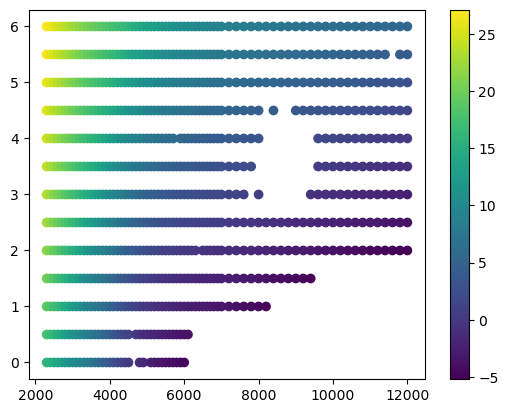

In [7]:
ufeh = np.unique(inarr[:,2])

msk = ufeh[0]==inarr[:,2]

plt.scatter(inarr[msk,0], inarr[msk,1], c=photarr[msk,0])
plt.colorbar()

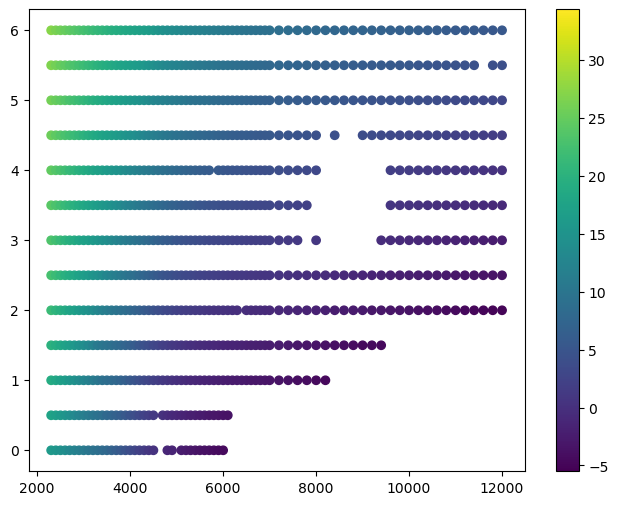

In [8]:
band_idx = 0

minmag = np.min(photarr[:, band_idx])
maxmag = np.max(photarr[:, band_idx])

ufeh = np.unique(inarr[:,2])

msk = ufeh[0]==inarr[:,2]

fig = plt.figure(figsize=(8,6))
plt.scatter(inarr[msk,0], inarr[msk,1], c=photarr[msk, band_idx], vmin=minmag, vmax=maxmag)
plt.colorbar()

In [9]:
def fanim(fehfidx):
    upperi = int(np.ceil(fehfidx))
    loweri = int(np.floor(fehfidx))
    
    umsk = ufeh[upperi]==inarr[:,2]
    lmsk = ufeh[loweri]==inarr[:,2]

    ualpha = (1 - (upperi - fehfidx))
    lalpha = (1 - (fehfidx - loweri))

    sckwargs = dict(vmin=minmag, vmax=maxmag, s=5, lw=0)

    ax = fig.axes[0]
    ax.cla()
    ax.scatter(inarr[umsk,0], inarr[umsk,1], c=photarr[umsk, band_idx], alpha=ualpha, **sckwargs)
    ax.scatter(inarr[lmsk,0], inarr[lmsk,1], c=photarr[lmsk, band_idx], alpha=lalpha, **sckwargs)
    ax.set_title(f'{fehfidx:.2f},{lalpha:.2f},{ualpha:.2f}')

fehfidxs = np.linspace(np.min(ufeh), np.max(ufeh),len(ufeh)*10)
anim = FuncAnimation(fig, fanim, fehfidxs, interval=100)
h5 = anim.to_html5_video()
display.HTML(h5)

In [10]:
plt.ioff()
for band_idx in tqdm(list(range(len(bandnms)))):
    bandnm = bandnms[band_idx]
    
    minmag = np.min(photarr[:, band_idx])
    maxmag = np.max(photarr[:, band_idx])
    
    ufeh = np.unique(inarr[:,2])
    
    msk = ufeh[0]==inarr[:,2]
    
    fig = plt.figure(figsize=(8,6))
    plt.scatter(inarr[msk,0], inarr[msk,1], c=photarr[msk, band_idx], vmin=minmag, vmax=maxmag)
    plt.colorbar()
    
    def fanim(fehfidx):
        upperi = int(np.ceil(fehfidx))
        loweri = int(np.floor(fehfidx))
        
        umsk = ufeh[upperi]==inarr[:,2]
        lmsk = ufeh[loweri]==inarr[:,2]
    
        ualpha = (1 - (upperi - fehfidx))
        lalpha = (1 - (fehfidx - loweri))
    
        sckwargs = dict(vmin=minmag, vmax=maxmag, s=5, lw=0)
    
        ax = fig.axes[0]
        ax.cla()
        ax.scatter(inarr[umsk,0], inarr[umsk,1], c=photarr[umsk, band_idx], alpha=ualpha, **sckwargs)
        ax.scatter(inarr[lmsk,0], inarr[lmsk,1], c=photarr[lmsk, band_idx], alpha=lalpha, **sckwargs)
        ax.set_title(f'{bandnm}:{fehfidx:.2f},{lalpha:.2f},{ualpha:.2f}')
    
    fehfidxs = np.linspace(np.min(ufeh), np.max(ufeh),len(ufeh)*10)
    anim = FuncAnimation(fig, fanim, fehfidxs, interval=100)
    h5 = anim.to_html5_video()
    display.display(display.HTML(h5))
plt.ion()

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
validation_idxs = np.random.permutation(len(inarr))[:50]
validation_msk = np.isin(np.arange(len(inarr)), validation_idxs)

(np.float64(-0.0012679287170370658), np.float64(0.08726151647725507))

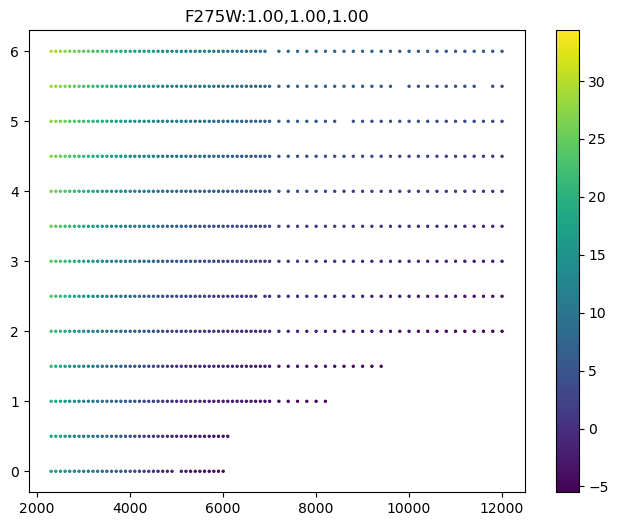

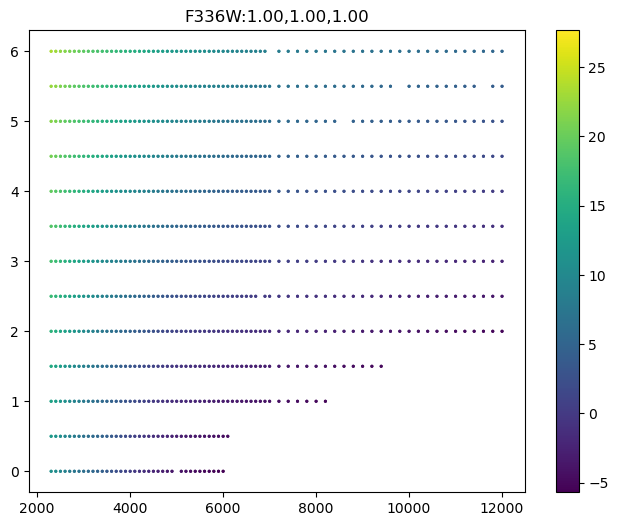

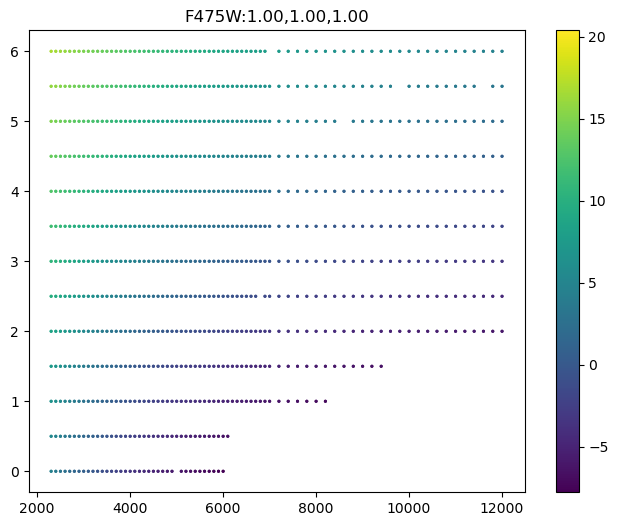

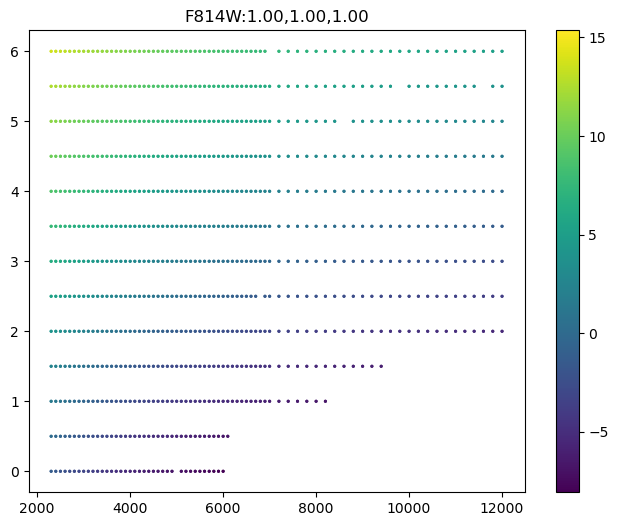

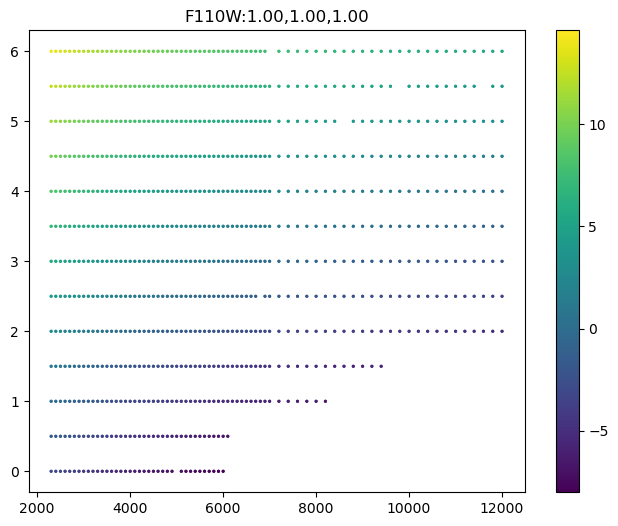

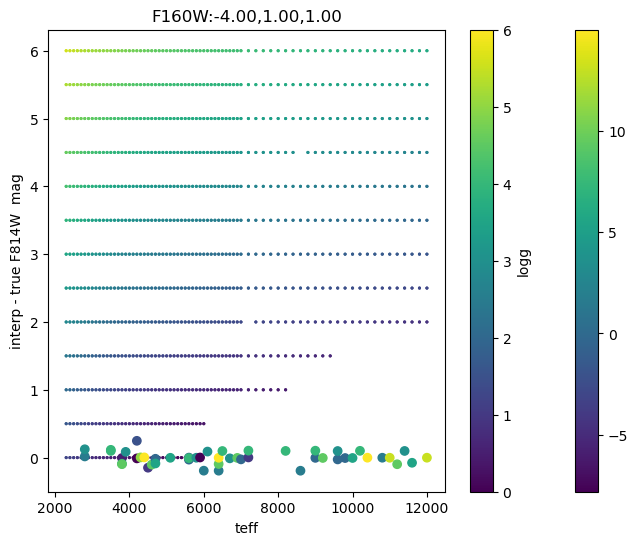

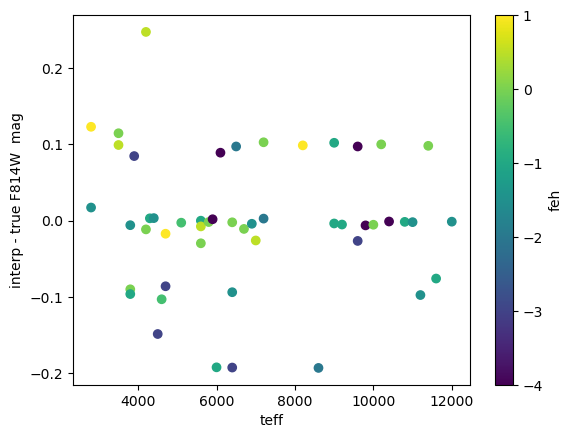

In [12]:
band_idx = 3
bandnm = bandnms[band_idx]

interp = interpolate.LinearNDInterpolator(inarr[~validation_msk], photarr[~validation_msk,band_idx])

err = interp(inarr[validation_msk]) - photarr[validation_msk, band_idx]

plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,1])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('logg')

plt.figure()
plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,2])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('feh')

np.mean(err), np.std(err)

(np.float64(0.015574506621878158), np.float64(0.15253255688830197))

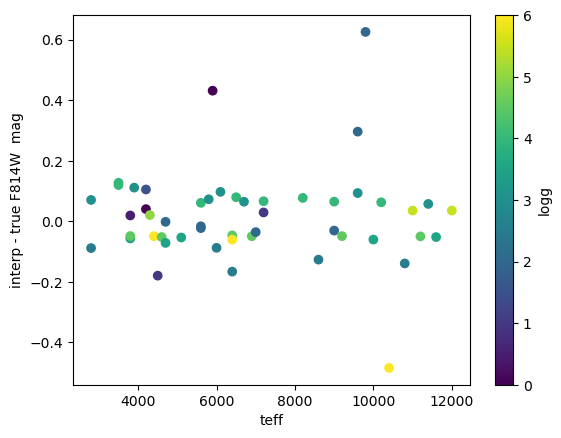

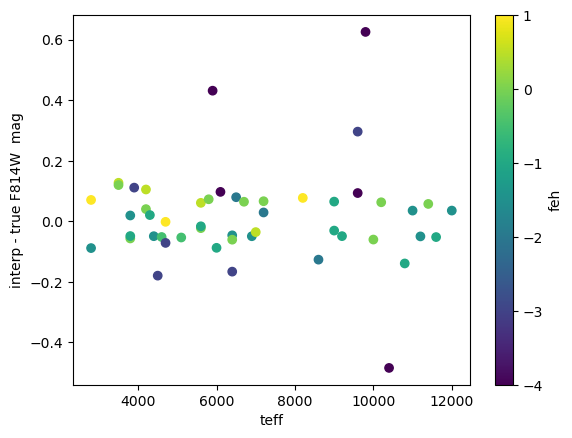

In [13]:
band_idx = 3
bandnm = bandnms[band_idx]

interp = interpolate.RBFInterpolator(inarr[~validation_msk], photarr[~validation_msk,3], kernel='linear')

err = interp(inarr[validation_msk]) - photarr[validation_msk, band_idx]

plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,1])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('logg')

plt.figure()
plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,2])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('feh')

np.mean(err), np.std(err)

(np.float64(0.006702876239917618), np.float64(0.07552393625575193))

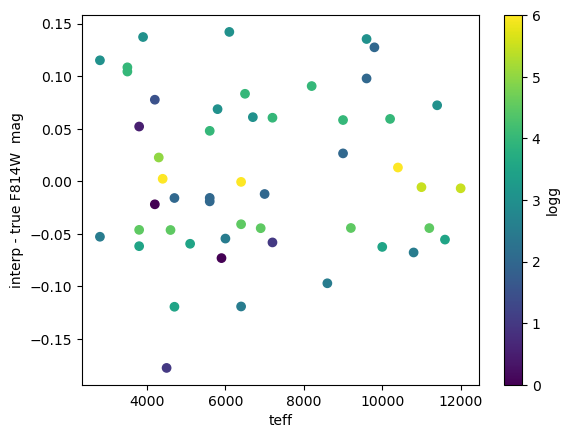

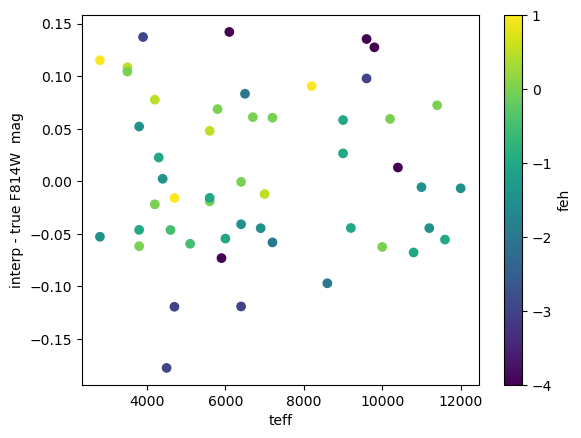

In [14]:
band_idx = 3
bandnm = bandnms[band_idx]

interp = interpolate.RBFInterpolator(inarr[~validation_msk], photarr[~validation_msk,3], kernel='thin_plate_spline')

err = interp(inarr[validation_msk]) - photarr[validation_msk, band_idx]

plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,1])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('logg')

plt.figure()
plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,2])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('feh')

np.mean(err), np.std(err)

(np.float64(0.07740258199950459), np.float64(0.31673234910399445))

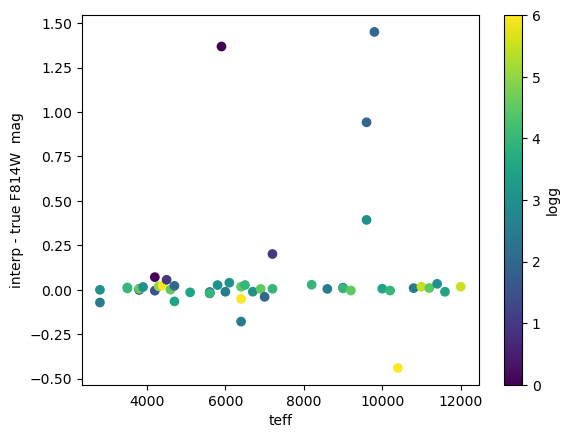

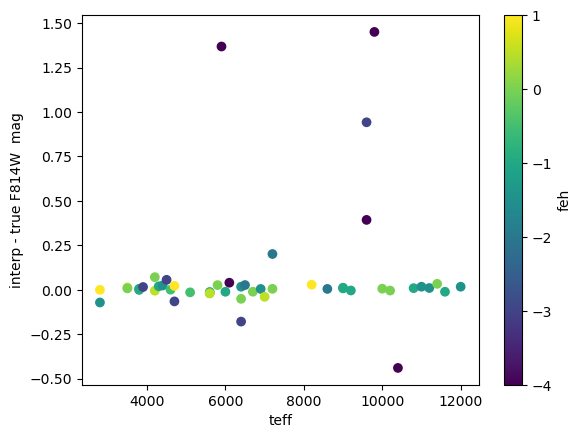

In [15]:
band_idx = 3
bandnm = bandnms[band_idx]

interp = interpolate.RBFInterpolator(inarr[~validation_msk], photarr[~validation_msk,3], kernel='gaussian', epsilon=1)

err = interp(inarr[validation_msk]) - photarr[validation_msk, band_idx]

plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,1])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('logg')

plt.figure()
plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,2])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('feh')

np.mean(err), np.std(err)

(np.float64(0.051766777924875204), np.float64(0.2538702224165493))

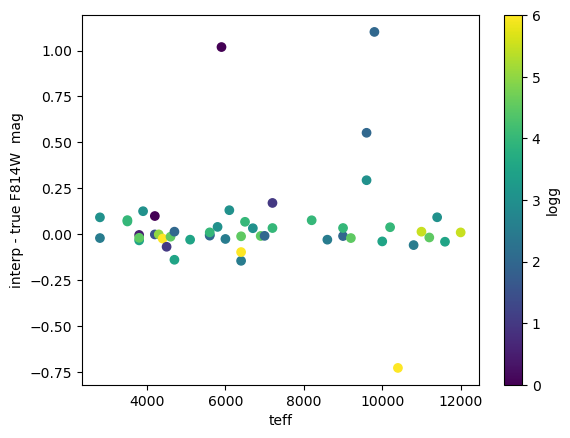

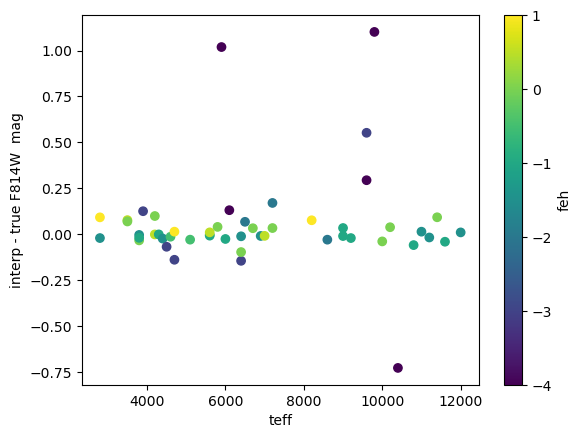

In [16]:
band_idx = 3
bandnm = bandnms[band_idx]

interp = interpolate.RBFInterpolator(inarr[~validation_msk], photarr[~validation_msk,3], kernel='inverse_multiquadric', epsilon=1)

err = interp(inarr[validation_msk]) - photarr[validation_msk, band_idx]

plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,1])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('logg')

plt.figure()
plt.scatter(inarr[validation_msk,0], err, c=inarr[validation_msk,2])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('feh')

np.mean(err), np.std(err)

Timing experiments

In [17]:
linterp = interpolate.LinearNDInterpolator(inarr, photarr[:,3])
%timeit linterp([(5800, 4.44, 0)]) # ~4.57 in F814W AB
linterp([(5800, 4.44, 0)])

794 μs ± 5.63 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


array([4.50237972])

In [18]:
rbf = interpolate.RBFInterpolator(inarr, photarr[:,3], kernel='linear')
%timeit rbf([(5800, 4.44, 0)])
rbf([(5800, 4.44, 0)])

49 μs ± 158 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([4.50469615])

In [19]:
rbf = interpolate.RBFInterpolator(inarr, photarr[:,3], kernel='thin_plate_spline')
%timeit rbf([(5800, 4.44, 0)])
rbf([(5800, 4.44, 0)])

76.7 μs ± 118 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([4.50662502])

In [20]:
rbf = interpolate.RBFInterpolator(inarr, photarr[:,3], kernel='gaussian', epsilon=1)
%timeit rbf([(5800, 4.44, 0)])
rbf([(5800, 4.44, 0)])

133 μs ± 274 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([4.49635509])

In [21]:
rbf = interpolate.RBFInterpolator(inarr, photarr[:,3], kernel='inverse_multiquadric', epsilon=1)
%timeit rbf([(5800, 4.44, 0)])
rbf([(5800, 4.44, 0)])

60.2 μs ± 117 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([4.50122235])

Consider some of the candidates more carefully

In [22]:
validation_idxs = np.random.permutation(len(inarr))[:250]
validation_msk = np.isin(np.arange(len(inarr)), validation_idxs)

In [23]:
linterp = interpolate.LinearNDInterpolator(inarr[~validation_msk], photarr[~validation_msk,band_idx])

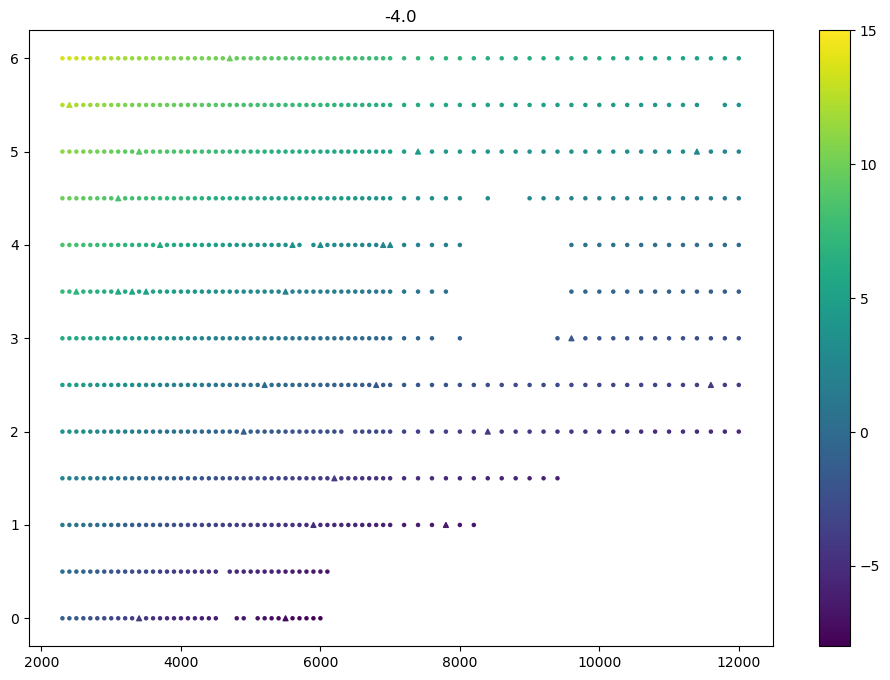

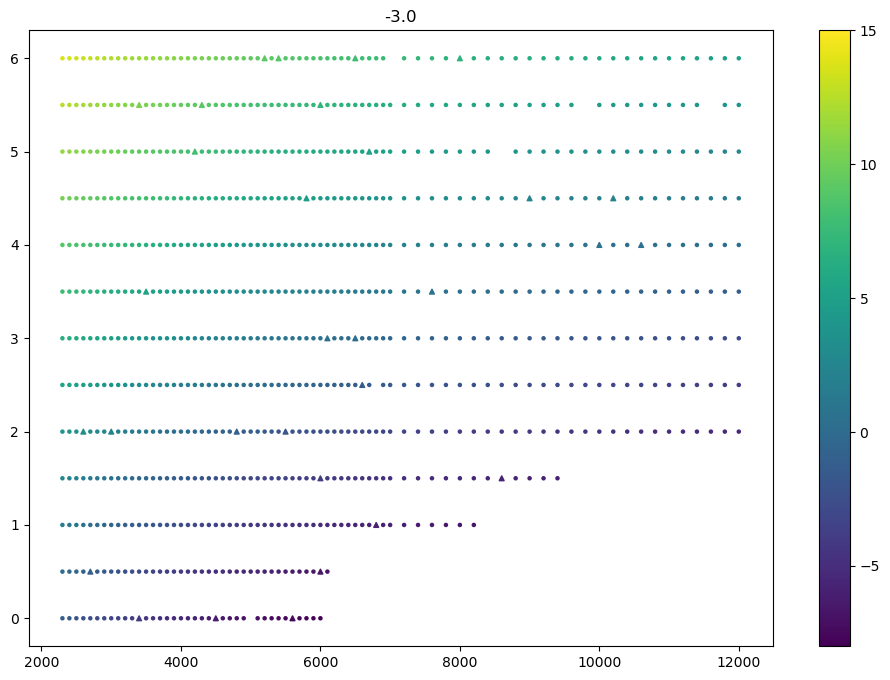

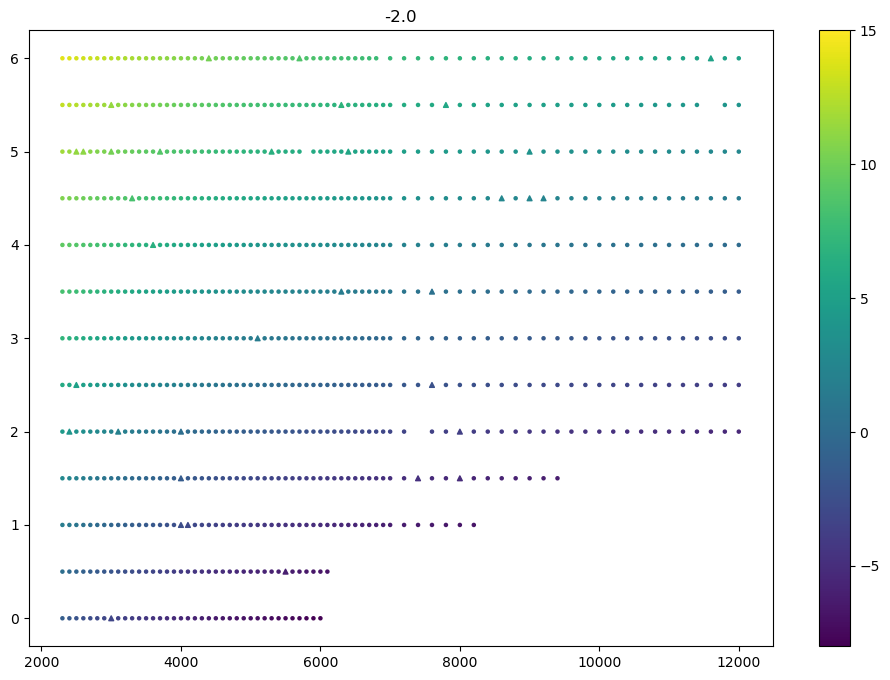

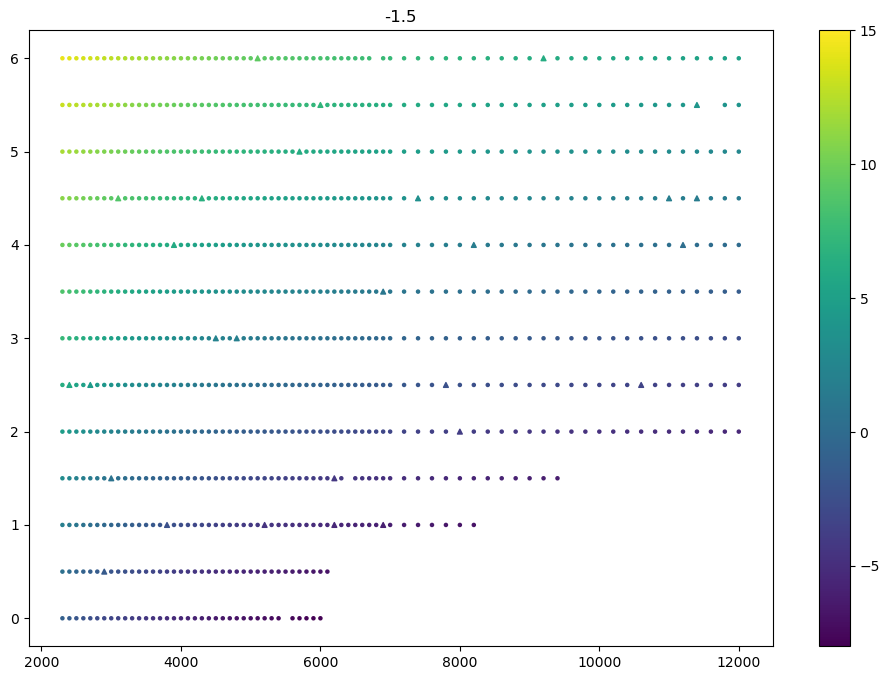

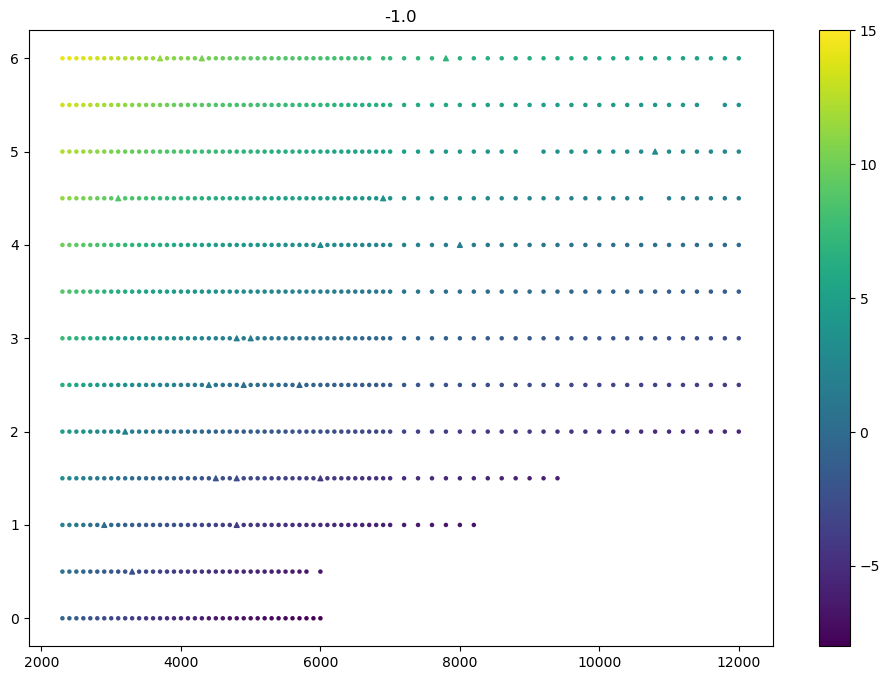

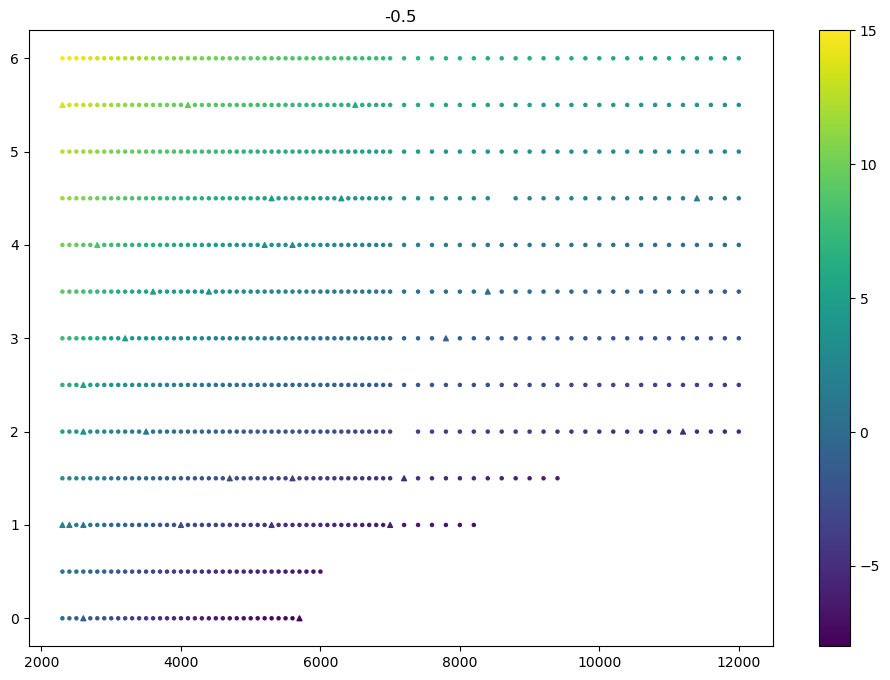

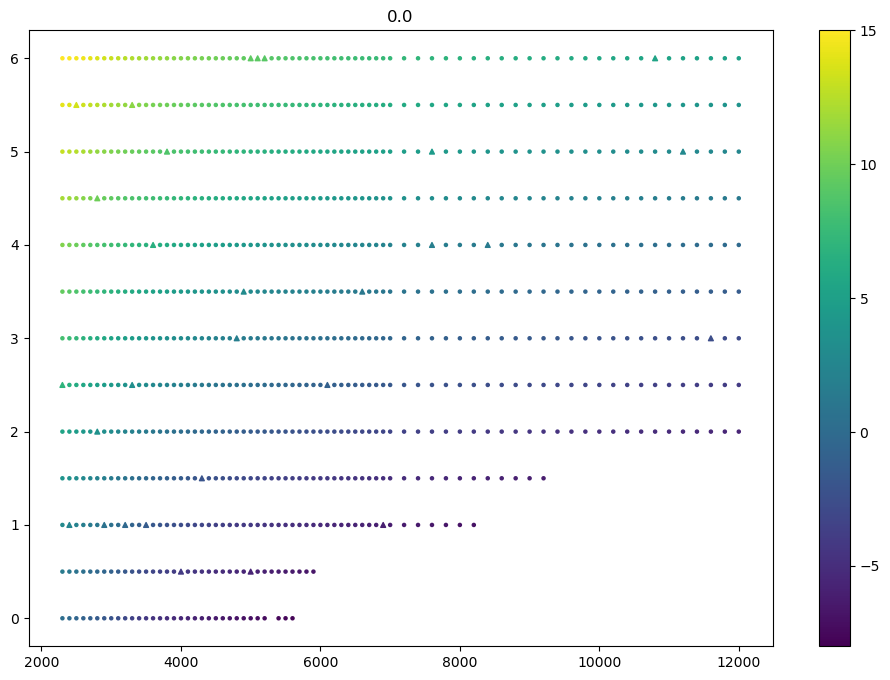

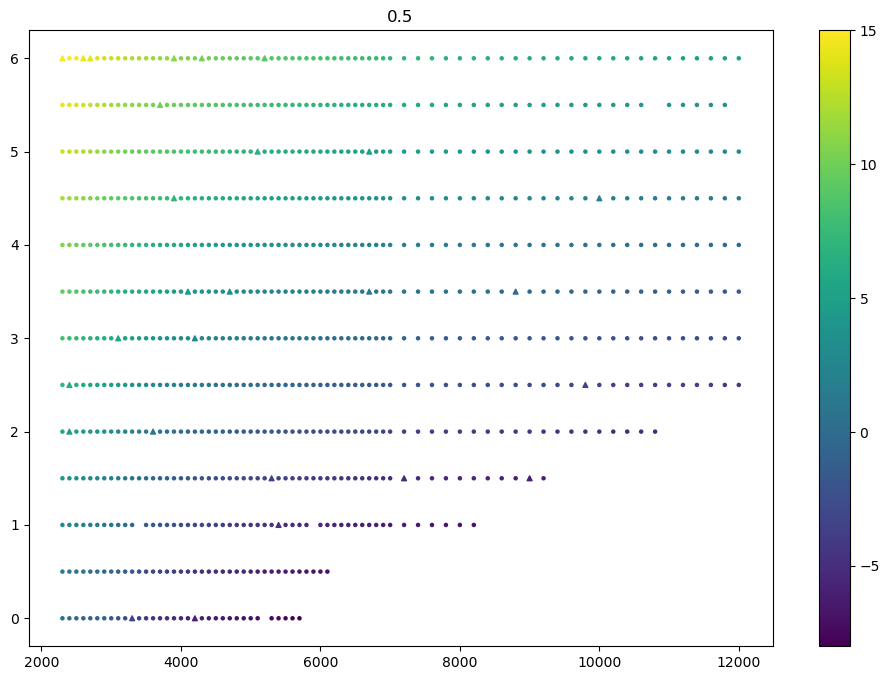

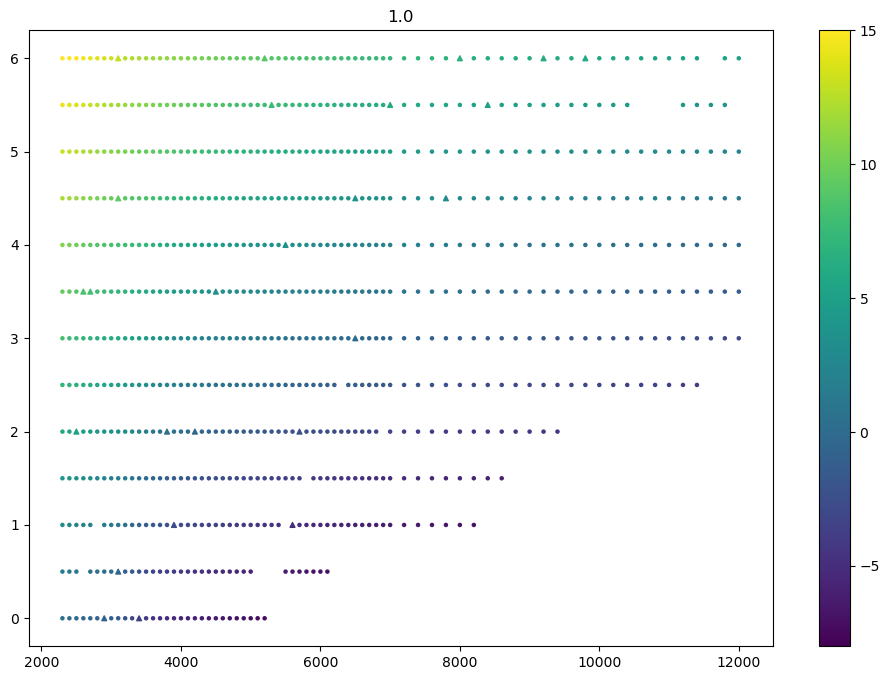

In [24]:
for feh in ufeh:
    msk = inarr[:, 2]==feh
    
    interpvals = linterp(inarr[validation_msk&msk])
    vmin=-8
    vmax=15
    
    plt.figure(figsize=(12, 8))
    plt.scatter(inarr[~validation_msk&msk, 0], inarr[~validation_msk&msk, 1], c=photarr[~validation_msk&msk,3], s=5, vmin=vmin, vmax=vmax)
    plt.scatter(inarr[validation_msk&msk, 0], inarr[validation_msk&msk, 1], c=interpvals, s=12, vmin=vmin, vmax=vmax, marker='^')
    plt.colorbar()
    plt.title(str(feh))

In [25]:
rbf = interpolate.RBFInterpolator(inarr[~validation_msk], photarr[~validation_msk,3], kernel='thin_plate_spline')

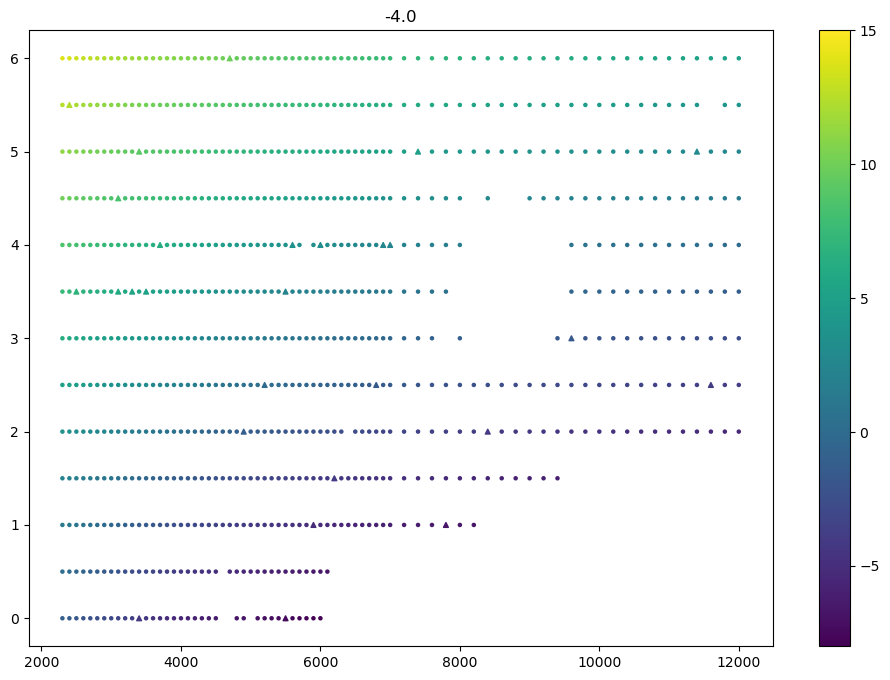

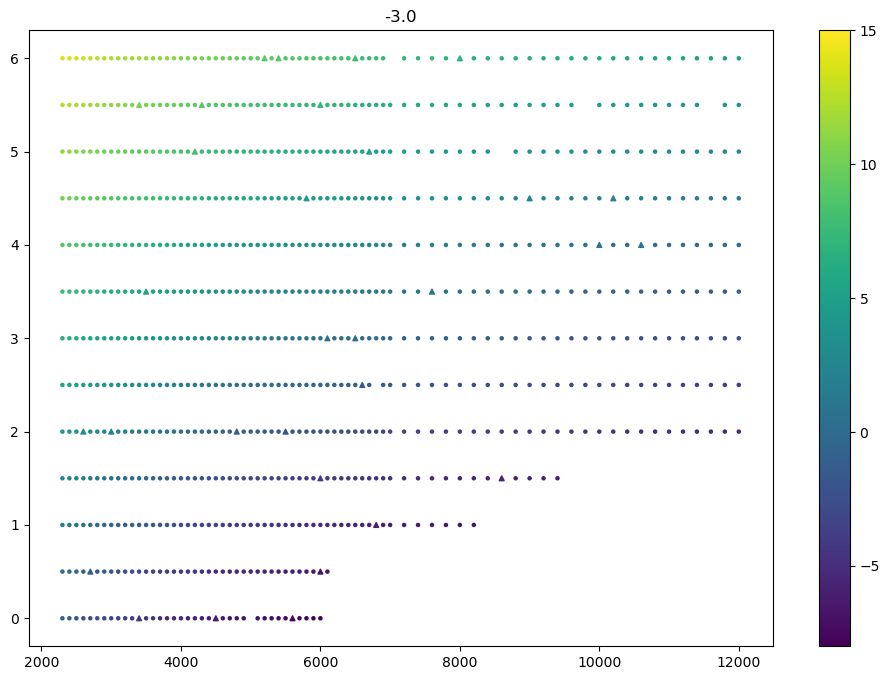

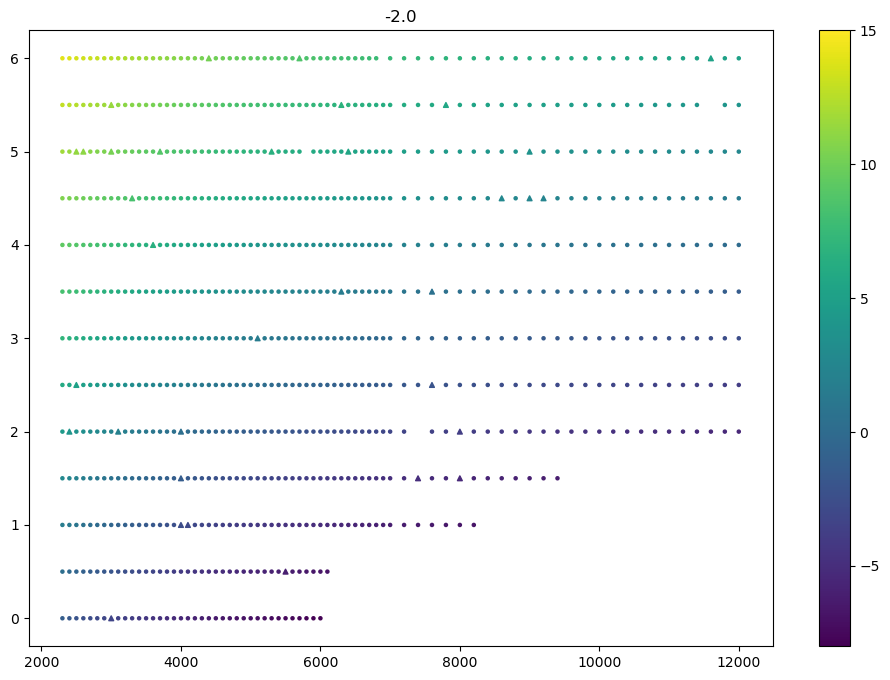

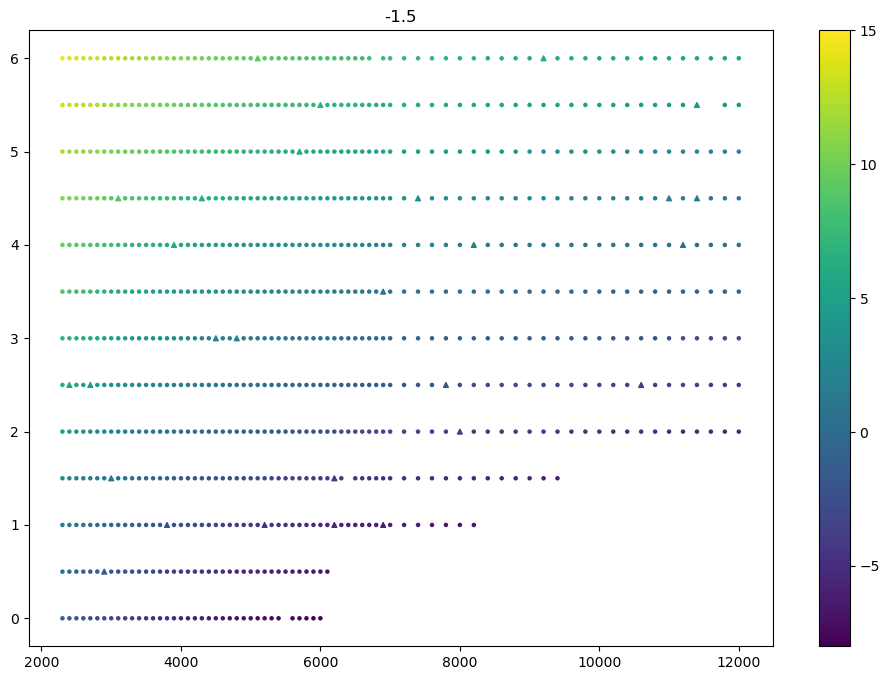

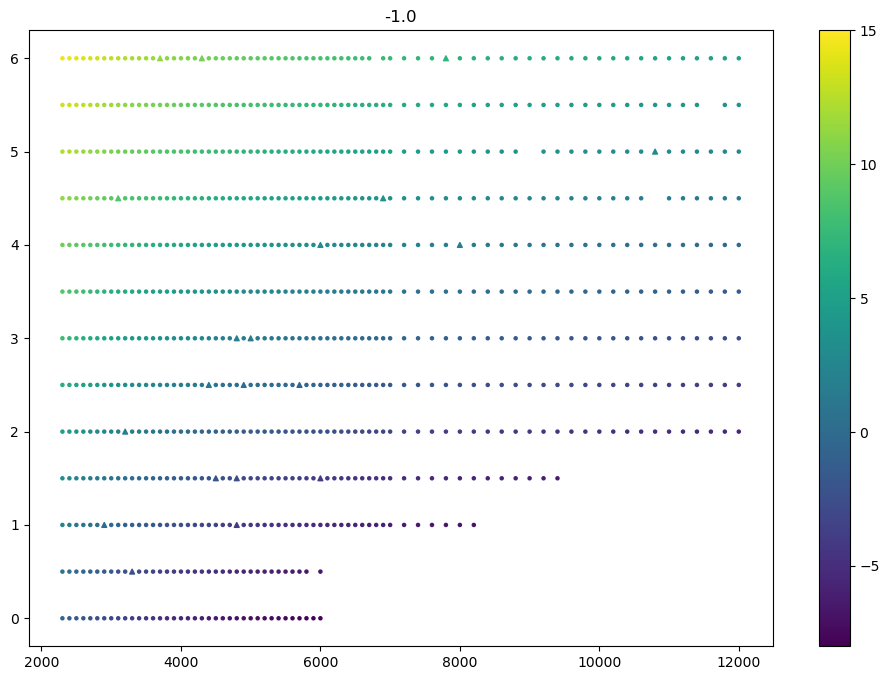

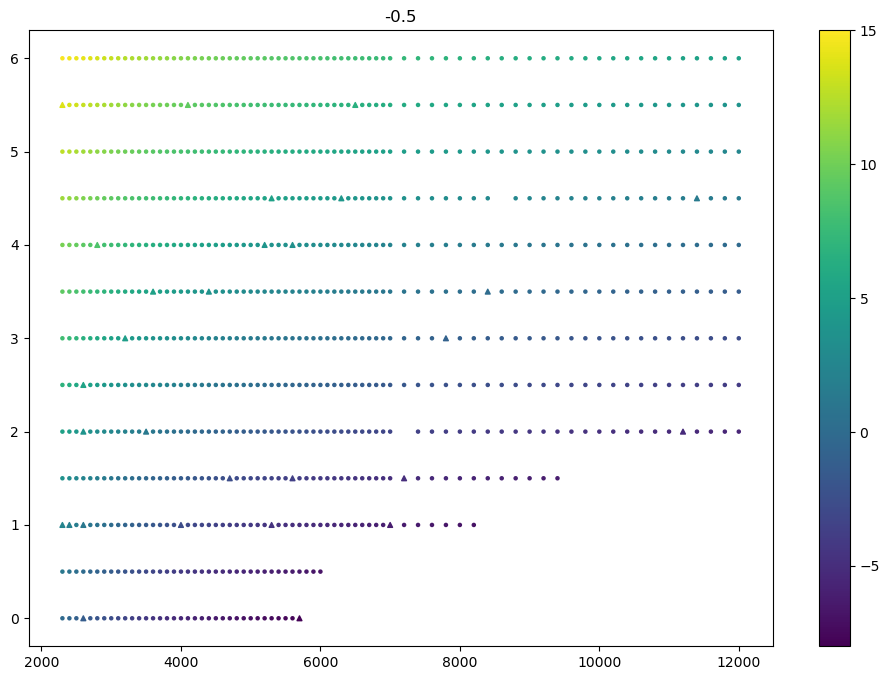

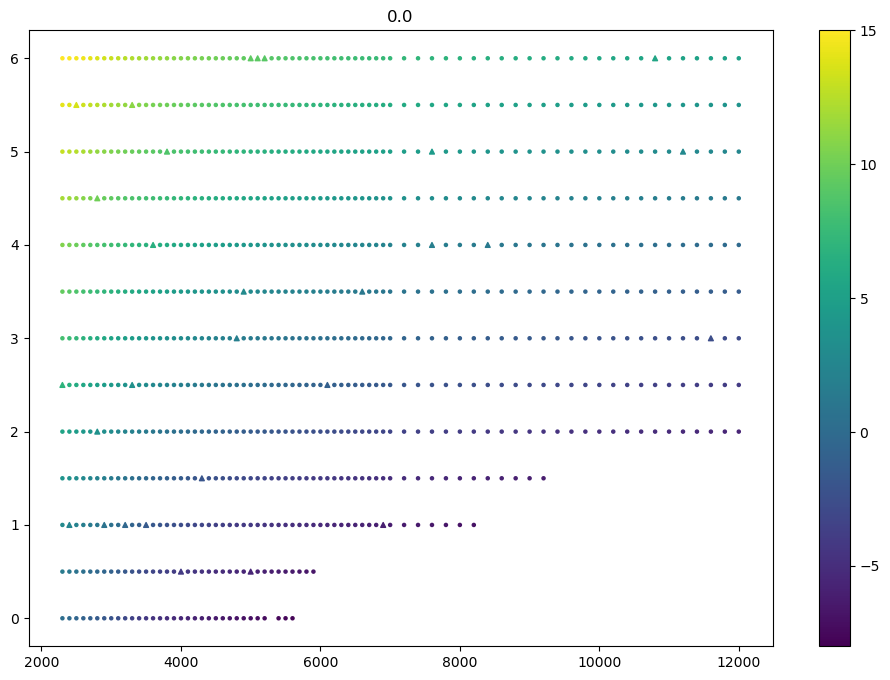

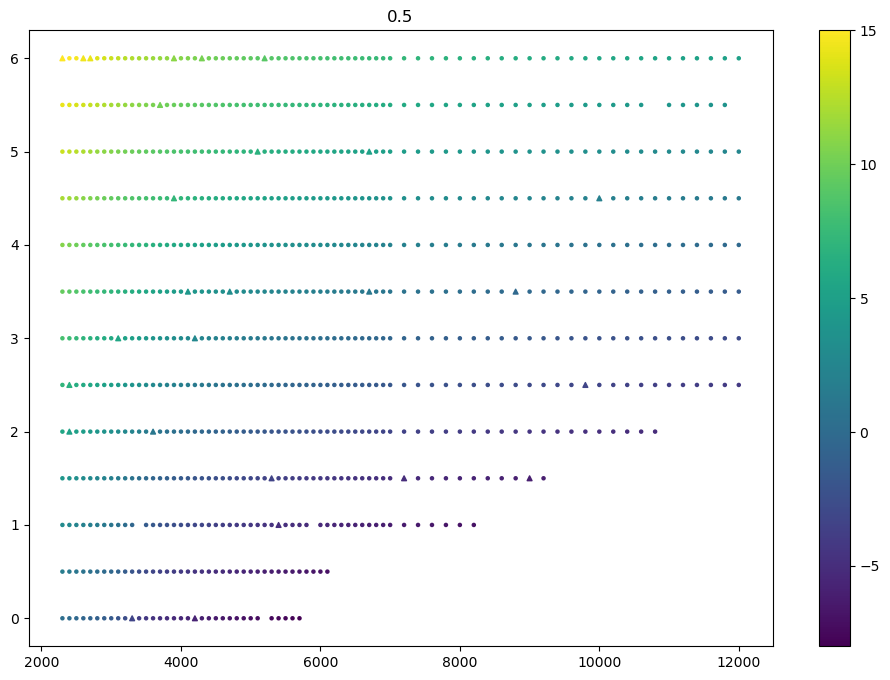

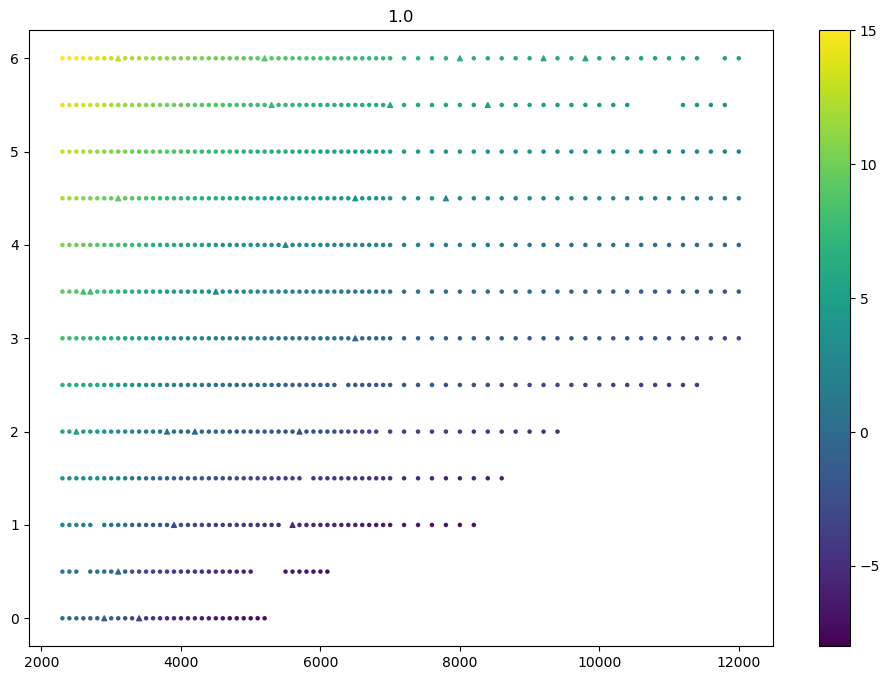

In [26]:
for feh in ufeh:
    msk = inarr[:, 2]==feh
    
    interpvals = rbf(inarr[validation_msk&msk])
    vmin=-8
    vmax=15
    
    plt.figure(figsize=(12, 8))
    plt.scatter(inarr[~validation_msk&msk, 0], inarr[~validation_msk&msk, 1], c=photarr[~validation_msk&msk,3], s=5, vmin=vmin, vmax=vmax)
    plt.scatter(inarr[validation_msk&msk, 0], inarr[validation_msk&msk, 1], c=interpvals, s=12, vmin=vmin, vmax=vmax, marker='^')
    plt.colorbar()
    plt.title(str(feh))

No visible issues.

What if we rescale the Teff to be smaller to weight the other variables more?

In [27]:
validation_idxs = np.random.permutation(len(inarr))[:50]
validation_msk = np.isin(np.arange(len(inarr)), validation_idxs)

In [28]:
inarr2 =  (inarr - np.min(inarr, axis=0))/np.ptp(inarr, axis=0)

(np.float64(nan), np.float64(nan))

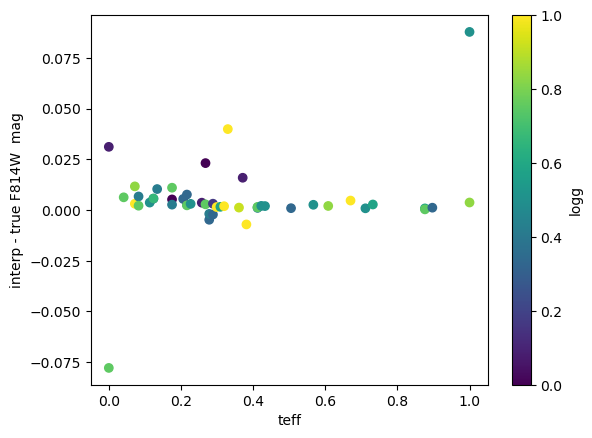

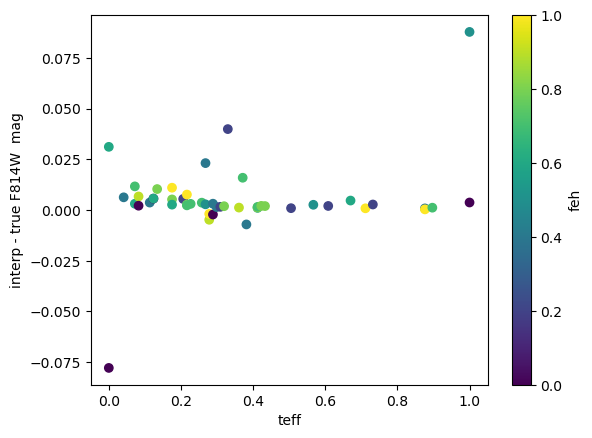

In [29]:
band_idx = 3
bandnm = bandnms[band_idx]

interp =  interpolate.LinearNDInterpolator(inarr2[~validation_msk], photarr[~validation_msk,band_idx])

err = interp(inarr2[validation_msk]) - photarr[validation_msk, band_idx]

plt.scatter(inarr2[validation_msk,0], err, c=inarr2[validation_msk,1])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('logg')

plt.figure()
plt.scatter(inarr2[validation_msk,0], err, c=inarr2[validation_msk,2])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('feh')

np.mean(err), np.std(err)

(np.float64(0.0010254461672657871), np.float64(0.009987801769464236))

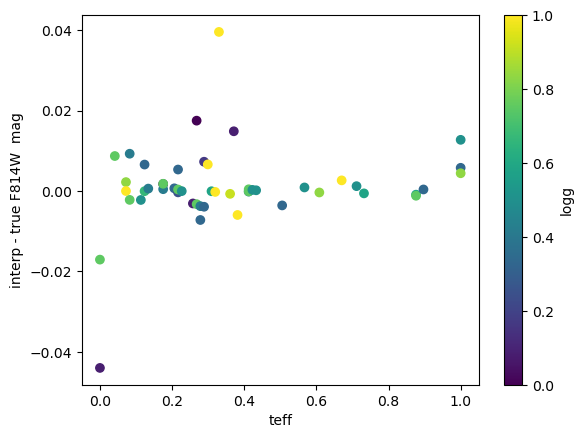

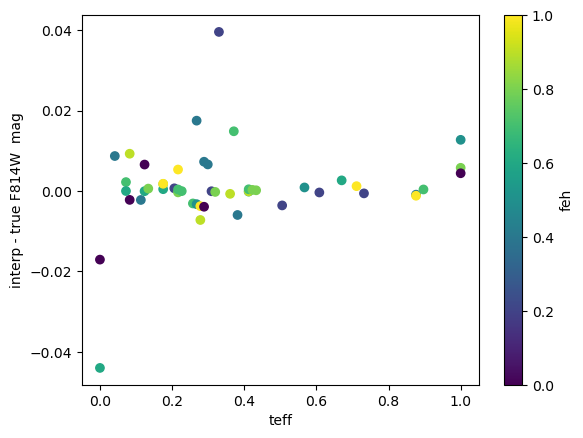

In [30]:
band_idx = 3
bandnm = bandnms[band_idx]

interp =  interpolate.RBFInterpolator(inarr2[~validation_msk], photarr[~validation_msk,3], kernel='thin_plate_spline')

err = interp(inarr2[validation_msk]) - photarr[validation_msk, band_idx]

plt.scatter(inarr2[validation_msk,0], err, c=inarr2[validation_msk,1])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('logg')

plt.figure()
plt.scatter(inarr2[validation_msk,0], err, c=inarr2[validation_msk,2])
plt.xlabel('teff')
plt.ylabel(f'interp - true {bandnm}  mag')
plt.colorbar().set_label('feh')

np.mean(err), np.std(err)

That seems to work well! But it doesn't seem right that the linear interpolator cares about scale.  Lets make some toy problem to confirm this.

In [31]:
x = np.linspace(-1, 1, 10)
y = x.copy()
z = x.copy()
xyz = np.array(np.meshgrid(x,y,z))
xr = xyz[0].ravel()
yr = xyz[1].ravel()
zr = xyz[2].ravel()

In [32]:
f = xr*yr*zr

interp = interpolate.LinearNDInterpolator(np.array([xr,yr,zr]).T, f)

In [33]:
icoo = np.array([[.3,.6,.8]])
interp(icoo), np.prod(icoo.ravel())

(array([0.14526749]), np.float64(0.144))

In [34]:
p = 100
q = 1
r = 2

fmod = f*p*q*r

xp = xr*p
yp = yr*q
zp = zr*r

interpp = interpolate.LinearNDInterpolator(np.array([xp,yp,zp]).T, fmod)

In [35]:
icoop = icoo*[p,q,r]
interpp(icoop), np.prod(icoop)

(array([27.46227709]), np.float64(28.8))

As expected it's linear... so why did it matter above? Oh... could it be nearest grid corners on a non-uniform grid?

In [165]:
np.random.seed(52) # chosen to demonstrate that small offset can be blown up by the rescaling
x,y,z = np.sort(np.random.randn(3, 10), axis=1)
xyz = np.array(np.meshgrid(x,y,z))
xr = xyz[0].ravel()
yr = xyz[1].ravel()
zr = xyz[2].ravel()

f = xr*yr*zr

interp = interpolate.LinearNDInterpolator(np.array([xr,yr,zr]).T, f)

icoo = np.array([[.3,.6,.1]])
interp(icoo), np.prod(icoo.ravel())

(array([0.0186909]), np.float64(0.018))

In [173]:
dr = np.sqrt((xr-icoo[0,0])**2+(yr-icoo[0,1])**2+(zr-icoo[0,2])**2)
np.argsort(dr)[:8]

array([743, 753, 763, 733, 773, 843, 853, 643])

In [166]:
p = 100
q = 1
r = 2

fmod = f*p*q*r

xp = xr*p
yp = yr*q
zp = zr*r

interpp = interpolate.LinearNDInterpolator(np.array([xp,yp,zp]).T, fmod)

icoop = icoo*[p,q,r]
interpp(icoop), np.prod(icoop)

(array([5.57702095]), np.float64(3.6))

In [175]:
dr = np.sqrt((xp-icoop[0,0])**2+(yp-icoop[0,1])**2+(zp-icoop[0,2])**2)
np.argsort(dr)[:8]

array([743, 843, 643, 543, 943, 744, 742, 443])

Not the same closest 8! That's probably what's happening.